In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold,train_test_split
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

from PIL import Image
import pandas as pd 
import math

import scipy.io

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
torch.cuda.is_available()
#subpolt

True

In [2]:
df=pd.read_excel('D:/Hossam59/try/Video_classification.xlsx')
data_dir='D:/Hossam59/try/VideoData_trimmed'



classification = np.where(df.Classification == 'Benign' , 0,1)
df['Class_Type'] = classification

In [3]:
class CEUS_Dataset(Dataset):
    def __init__ (self,df, train:bool = True):
        self.df=df
        self.train=train
        
        #device = torch.device('cuda:0')
        #
        
        
    def __getitem__(self,index):
        pat_name=self.df['Pat_code'].iloc[index]
        filename=data_dir+'/'+pat_name+'.mat'
        # loading mat file
        mat = scipy.io.loadmat(filename)
        
        c=mat['xceus_red']
        #resizeing images
        x = transforms.ToTensor()(c)
        x = transforms.Resize(300)(x)
        #changing type to float
        x=x.unsqueeze(0).type(torch.FloatTensor)

        if(self.train):
            y= self.df['Class_Type'].iloc[index]
            
            return x,y
        else:
            return x
        
    def __len__(self):
        return len (self.df)
    
    
    
    
    
    
df_train, df_test = train_test_split(df)

train_dataset=CEUS_Dataset(
    df=df_train,
    train=True,
)

train_loader=DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    drop_last=True,
)


test_dataset=CEUS_Dataset(
    df=df_test,
    train=True,
)

test_loader=DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=False,
    drop_last=True,
)
m=len(train_dataset)

images, labels=next(iter(train_loader))

In [4]:
class CNN_3d(nn.Module):

    def __init__(self, in_ch, out_ch, BN3D="use_it"):
        super().__init__()
        if BN3D == "use_it":
            self.conv3d = nn.Sequential(
                nn.Conv3d(in_channels=in_ch, out_channels=out_ch, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(out_ch),
                nn.ReLU(inplace=True),
            )
        else:
            self.conv3d = nn.Sequential(
                nn.Conv3d(in_channels=in_ch, out_channels=out_ch, kernel_size=(3, 3, 3), padding=1),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        out = self.conv3d(x)
        return out
    
    
class SAC_1D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SAC_1D, self).__init__()
        self.con3D_1 = nn.Sequential(
            nn.Conv3d(in_channels=in_ch, out_channels=in_ch, kernel_size=(1, 1, 1)),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.con3D_1(x)
    
    
    
    
class SAC_3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SAC_3D, self).__init__()
        self.con3D_3 = nn.Sequential(
            nn.Conv3d(in_channels=in_ch, out_channels=in_ch, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.con3D_3(x)

In [5]:
class SAM(nn.Module):

    def __init__(self,in_cha):
        super(SAM,self).__init__()
        self.in_ch = in_cha
        
        
        self.start = CNN_3d(in_ch = in_cha, out_ch=in_cha, BN3D="use_it")
        self.q_c_1 = SAC_1D(in_ch = in_cha , out_ch = in_cha//8)
        self.k_c_1 = SAC_1D(in_ch = in_cha , out_ch = in_cha//8)
        self.v_c_3 = CNN_3d(in_ch = in_cha, out_ch=in_cha, BN3D="no")
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) 
    def forward(self,x):
        
        x = self.start(x)

        N,C,D,W,H = x.size()

        s_q  = self.q_c_1(x).view(N,-1,W*H).permute(0,2,1) 
        s_k =  self.k_c_1(x).view(N,-1,W*H) 
        s_qk =  torch.bmm(s_q,s_k) 
        s = self.softmax(s_qk) 

        d_q = self.q_c_1(x).view(N,-1,D).permute(0,2,1)
        d_k = self.k_c_1(x).view(N,-1,D)
        d_qk =  torch.bmm(d_q,d_k)
        d = self.softmax(d_qk)

        s_v = self.v_c_3(x).view(N,-1,W*H) 
        s_at = torch.bmm(s_v,s.permute(0,2,1))
        s_at = s_at.view(N,C,D,W,H)


        d_v = self.v_c_3(x).view(N,-1,D)
        d_at = torch.bmm(d_v,d.permute(0,2,1))
        d_at = d_at.view(N,C,D,W,H)
        
        Y = self.gamma*(s_at+d_at) + x
        
        return Y

In [6]:
class CNN_SA_Model(nn.Module):
    def __init__(self):
        super(CNN_SA_Model, self).__init__()
        self.input_channels = 1
        
        self.lay1 = CNN_3d(in_ch=self.input_channels, out_ch=32,BN3D="no")
        #self.lay2 = CNN_3d(in_ch=16, out_ch=32,BN3D="no") 
        self.lay3 = SAM(in_cha=32)
        self.lay4 = CNN_3d(in_ch=32, out_ch=64,BN3D="use_it")
        self.lay6 = SAM(in_cha=32)
        self.pool = nn.MaxPool3d((2, 4, 4))
        self.fc1 = nn.Linear(155520, 120) #311040, 245760 for 64  & 983040 for 128  & 3932160 for 256 & 288, 2400000...145152
        self.fc2 = nn.Linear(120, 2)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax(dim=1)
        
        self.drop=nn.Dropout(p=0.25)
        self.drop2=nn.Dropout(p=0.5)

    def forward(self, x):
        
        x = self.lay1(x)
        x = self.pool(x)
        t = self.lay3(x)
        r = x+t
        s = self.lay6(r)
        g = x+s
        
        v = self.pool(g)
        v = self.drop(v)
        
        u = v.view(v.size(0), -1)
        u = self.drop(u)
        u = self.relu(self.fc1(u))
        u = self.drop2(u)
        u = self.soft(self.fc2(u))
        #u = self.fc2(u)
        return u
    
model = CNN_SA_Model()

In [7]:
#device = torch.device('cuda:0')

def train_epoch(model,dataloader,loss_fn,optimizer): 
    model=model.to(device)
    train_loss,train_correct=0.0,0
    model.train()

    for images, labels in dataloader:
        labels=labels.type(torch.LongTensor).to(device)
        
        images=images.to(device)
        
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output,labels)
            loss.backward()
            optimizer.step()
            
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

In [8]:
def test_epoch(model,dataloader,loss_fn):
    model=model.to(device)
    test_loss, test_correct = 0.0, 0
    model.eval()
    confusion_matrix = torch.zeros(2, 2)
    for images, labels in dataloader:
        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        with torch.set_grad_enabled(False):
            output = model(images)
            loss=loss_fn(output,labels)

        test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        test_correct+=(predictions == labels).sum().item()
        for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

    return test_loss,test_correct,confusion_matrix

Fold Number= 1
Epoch:1/50 Train_Loss:0.81 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:2/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:3/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:4/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:5/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:6/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:7/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:8/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:9/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:10/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:11/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:12/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78 % Test_Acc 88.89 %
Epoch:13/50 Train_Loss:0.79 Test_Loss:0.42 Train_Acc 52.78

Epoch:6/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:7/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:8/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:9/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:10/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:11/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:12/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:13/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:14/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:15/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:16/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:17/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:18/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Ac

Epoch:11/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:12/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:13/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:14/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:15/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:16/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:17/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:18/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:19/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:20/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:21/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:22/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Test_Acc 44.44 %
Epoch:23/50 Train_Loss:0.67 Test_Loss:0.87 Train_Acc 63.89 % Tes

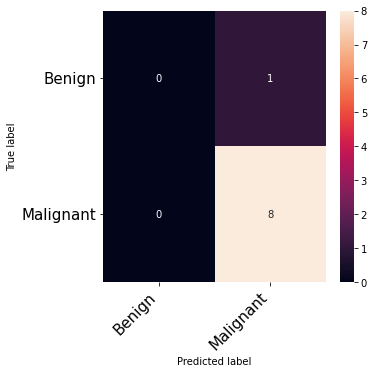

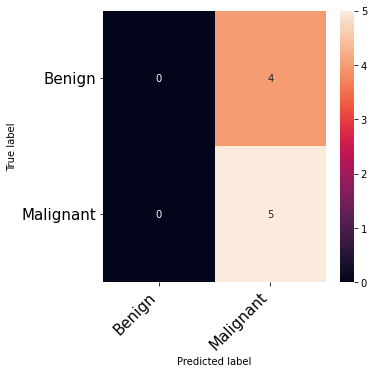

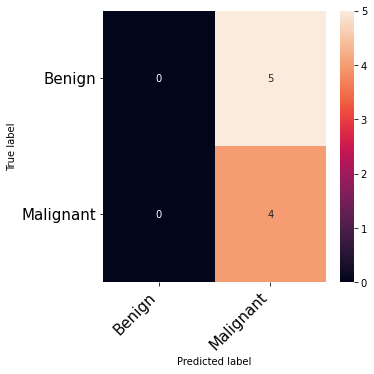

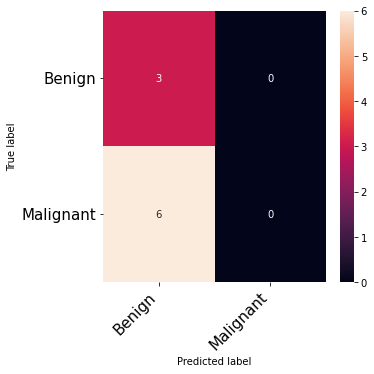

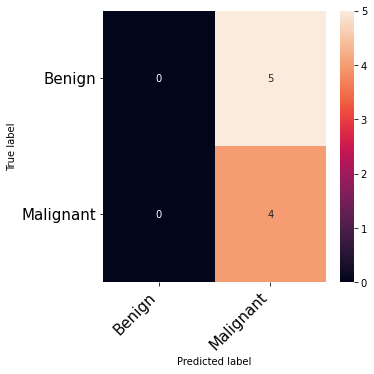

In [9]:
#model name = SAttCNN_s_K5F

b_s=3

device = torch.device('cuda:0')


error = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

dataset=CEUS_Dataset(df, train=True)


num_epochs=50

k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

foldperf={}


for fold, (train_x,test_x) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold Number= {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_x)
    test_sampler = SubsetRandomSampler(test_x)
    trainLoader = DataLoader(dataset, batch_size=b_s,  sampler=train_sampler)
    testLoader = DataLoader(dataset, batch_size=b_s, sampler=test_sampler)
    
    model = CNN_SA_Model()
    
    
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    

    l_a = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        
        train_loss, train_correct=train_epoch(model,trainLoader,error,optimizer)
        test_loss, test_correct,e=test_epoch(model,testLoader,error)

        train_loss = train_loss / len(trainLoader.sampler)
        train_acc = train_correct / len(trainLoader.sampler) * 100
        test_loss = test_loss / len(testLoader.sampler)
        test_acc = test_correct / len(testLoader.sampler) * 100

        print("Epoch:{}/{} Train_Loss:{:.2f} Test_Loss:{:.2f} Train_Acc {:.2f} % Test_Acc {:.2f} %".format(epoch + 1, 
                                                                                                       num_epochs, 
                                                                                                       train_loss, 
                                                                                                       test_loss, 
                                                                                                       train_acc, 
                                                                                                       test_acc))
        
        #train_loss, train_correct=train_epoch(model,train_loader,error,optimizer)
        #test_loss, test_correct,e=test_epoch(model,test_loader,error)

        l_a['train_loss'].append(train_loss)
        l_a['test_loss'].append(test_loss)
        l_a['train_acc'].append(train_acc)
        l_a['test_acc'].append(test_acc)
        
    plt.figure(figsize=(5,5))    
    test_loss, test_correct,e=test_epoch(model,testLoader,error)
    df_cm = pd.DataFrame(e, index=["Benign", "Malignant"], columns=["Benign", "Malignant"]).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

        
        
    foldperf['fold{}'.format(fold+1)] = l_a

In [10]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('{} fold cross validation'.format(k))

print("Avg Training Loss: {:.3f} \t Avg Test Loss: {:.3f} \t Avg Training Acc: {:.2f} \t Avg Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

5 fold cross validation
Avg Training Loss: 0.747 	 Avg Test Loss: 0.780 	 Avg Training Acc: 56.64 	 Avg Test Acc: 53.33


In [11]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

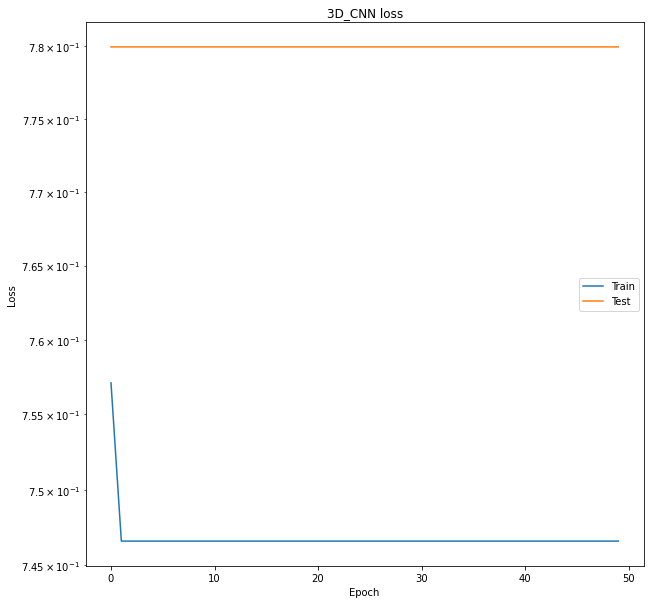

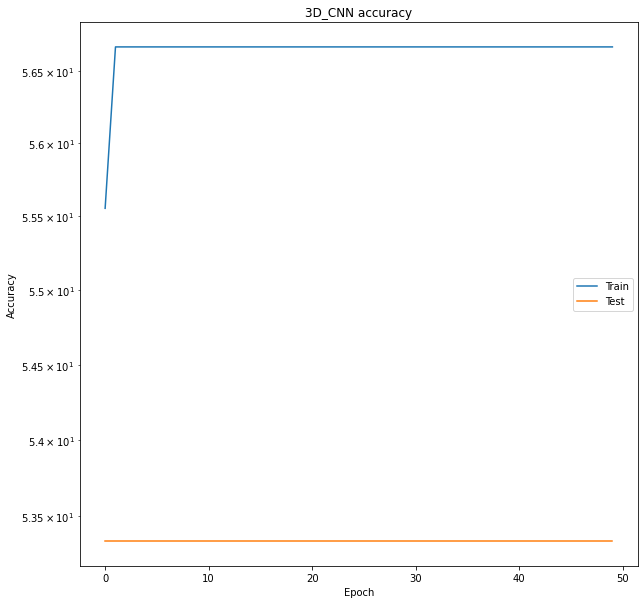

In [12]:
# Plot losses
plt.figure(figsize=(10,10))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('3D_CNN loss')
plt.show()

# Plot accuracies
plt.figure(figsize=(10,10))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('3D_CNN accuracy')
plt.show()

Epoch:1/100 Train_Loss:0.76 Test_Loss:0.73 Train_Acc 54.55 % Test_Acc 58.33 %
Epoch:2/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:3/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:4/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:5/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:6/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:7/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:8/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:9/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:10/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:11/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:12/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 % Test_Acc 58.33 %
Epoch:13/100 Train_Loss:0.71 Test_Loss:0.73 Train_Acc 60.61 %

Text(0.5, 24.0, 'Predicted label')

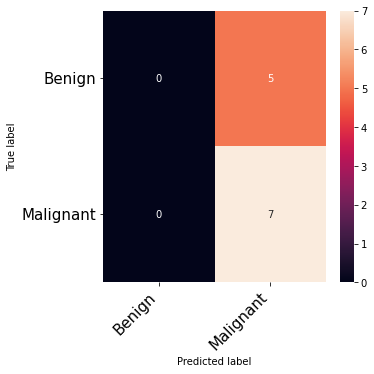

In [7]:
#model name = SAttCNN_s
device = torch.device('cuda:0')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


num_epochs=100
batch_size=3

l_a = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for epoch in range(num_epochs):
    
    model=model.to(device)
    
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in train_loader:

        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output,labels)
            loss.backward()
            optimizer.step()
            
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    
    test_loss, test_correct = 0.0, 0
    model.eval() 
    confusion_matrix = torch.zeros(2, 2)
    
    for images, labels in test_loader:
        
        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        
        with torch.set_grad_enabled(False):
            output = model(images)
            loss=loss_fn(output,labels)

            test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        test_correct+=(predictions == labels).sum().item()
        
        for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        
        

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} Train_Loss:{:.2f} Test_Loss:{:.2f} Train_Acc {:.2f} % Test_Acc {:.2f} %".format(epoch + 1, 
                                                                                                       num_epochs, 
                                                                                                       train_loss, 
                                                                                                       test_loss, 
                                                                                                       train_acc, 
                                                                                                       test_acc))
    
    
    l_a['train_loss'].append(train_loss)
    l_a['test_loss'].append(test_loss)
    l_a['train_acc'].append(train_acc)
    l_a['test_acc'].append(test_acc)
    
    
    
plt.figure(figsize=(5,5))    

df_cm = pd.DataFrame(confusion_matrix, index=["Benign", "Malignant"], columns=["Benign", "Malignant"]).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [8]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]


tl_f.append(np.mean(l_a['train_loss']))
testl_f.append(np.mean(l_a['test_loss']))
ta_f.append(np.mean(l_a['train_acc']))
testa_f.append(np.mean(l_a['test_acc']))

print("Avg Training Loss: {:.3f} \t Avg Test Loss: {:.3f} \t Avg Training Acc: {:.2f} \t Avg Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

Avg Training Loss: 0.708 	 Avg Test Loss: 0.730 	 Avg Training Acc: 60.55 	 Avg Test Acc: 58.33


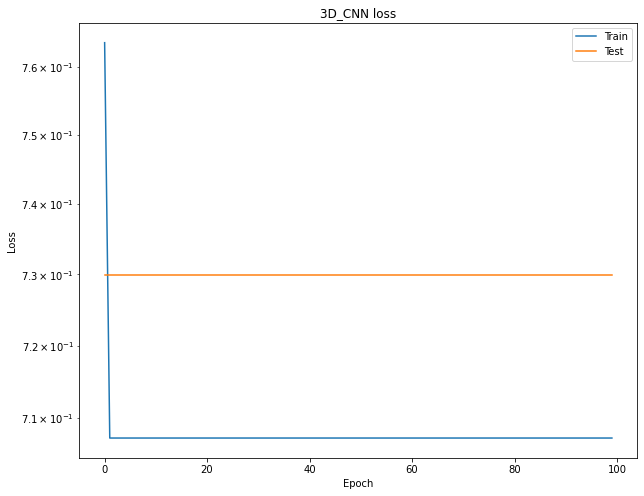

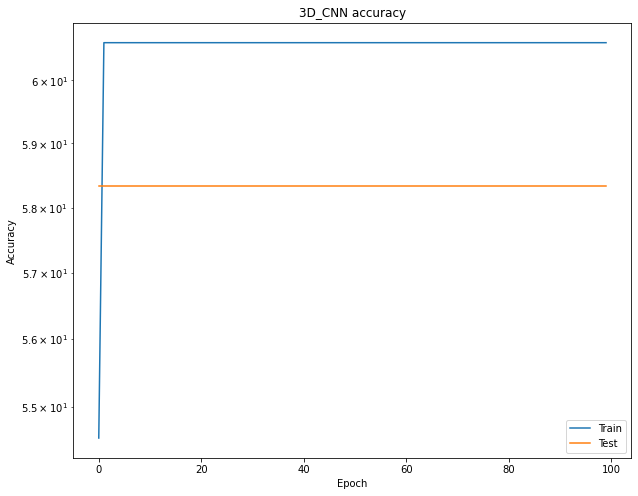

In [9]:
# Plot losses  
plt.figure(figsize=(10,8))
plt.semilogy(l_a['train_loss'], label='Train')
plt.semilogy(l_a['test_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('3D_CNN loss')
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(l_a['train_acc'], label='Train')
plt.semilogy(l_a['test_acc'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('3D_CNN accuracy')
plt.show()